# Laboratorio 9: AdaBoost y contenedores

**Duración:** 2 horas  
**Formato:** Competencia con contenedores  

---

## Portada del equipo

**Integrantes:**
- Nombre 1 (Usuario GitHub)
- Nombre 2 AlegreVentura
- Nombre 3 (Usuario GitHub)


**Fecha de entrega:**  
08/11/2025

### Primero hacemos un análisis exploratorio para tener idea de qué preprocesamiento hacer

Forma del dataset: (641, 8) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    641 non-null    int64  
 1   sex       641 non-null    object 
 2   age       434 non-null    float64
 3   sibsp     641 non-null    int64  
 4   parch     641 non-null    int64  
 5   fare      569 non-null    float64
 6   embarked  555 non-null    object 
 7   survived  641 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 40.2+ KB

Valores nulos por columna:
 pclass        0
sex           0
age         207
sibsp         0
parch         0
fare         72
embarked     86
survived      0
dtype: int64

Estadísticas descriptivas:
           count unique   top freq       mean        std   min     25%   50%  \
pclass    641.0    NaN   NaN  NaN   2.316693   0.833584   1.0     2.0   3.0   
sex         641      2  male  421        NaN        NaN 

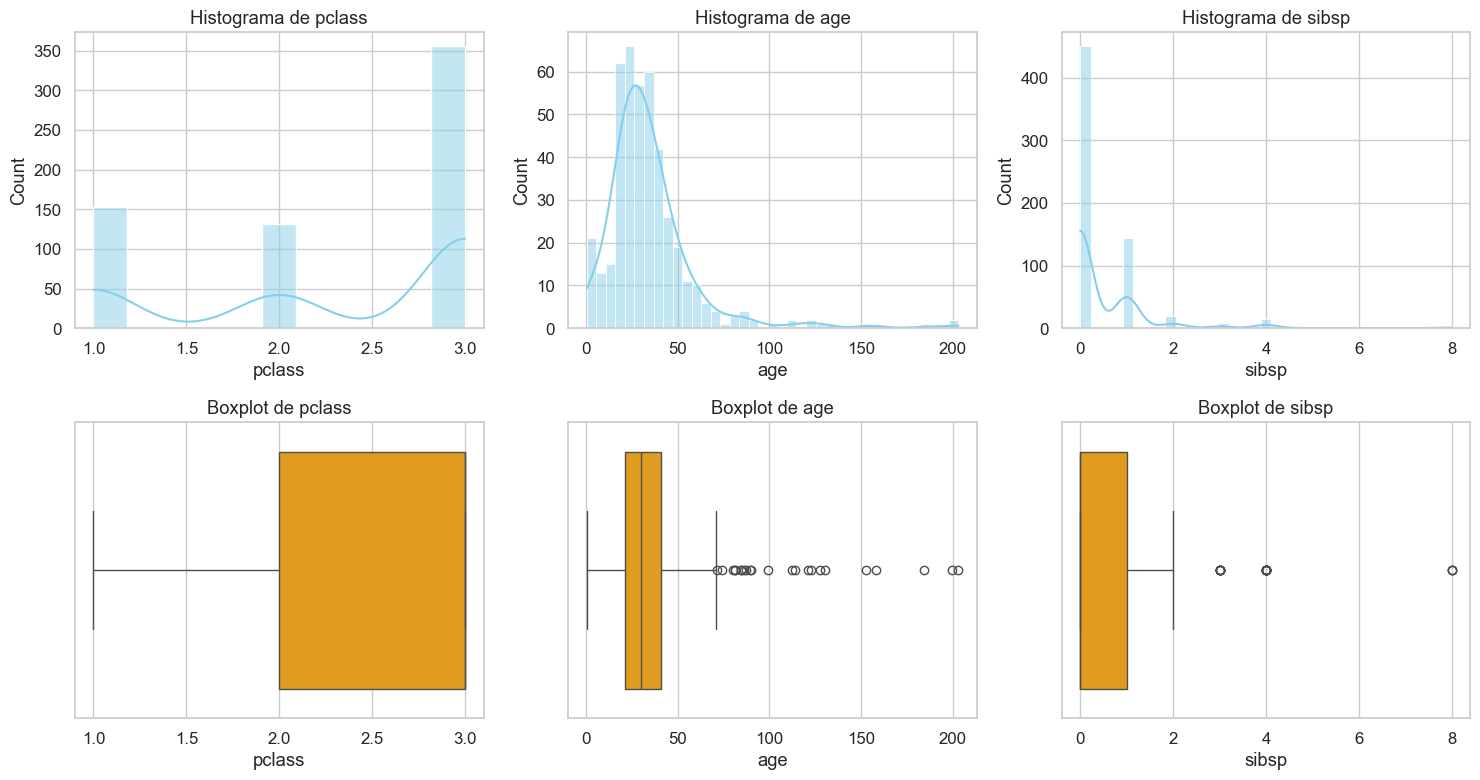

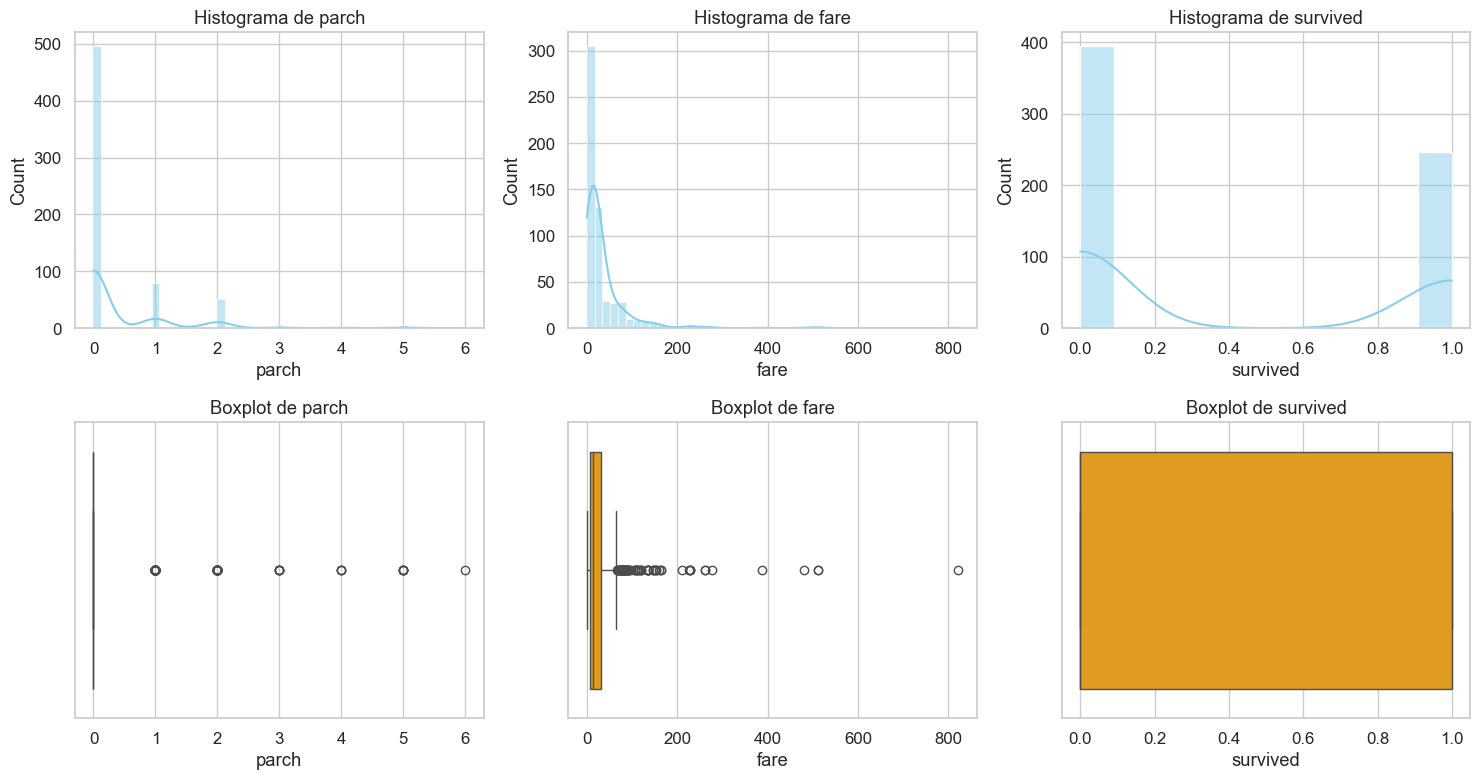

C:\Users\david\AppData\Local\Temp\ipykernel_11556\3815709943.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\david\AppData\Local\Temp\ipykernel_11556\3815709943.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


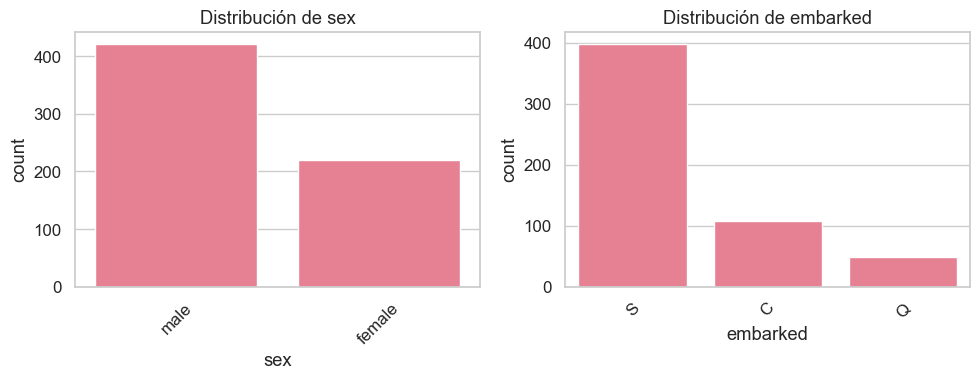

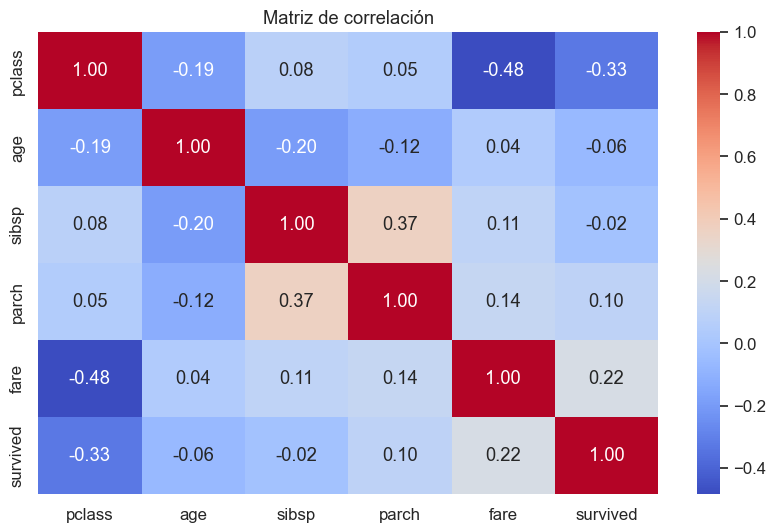


Posibles outliers detectados (|z|>3):
 pclass       0
age         11
sibsp       18
parch       14
fare        11
survived     0
dtype: int64


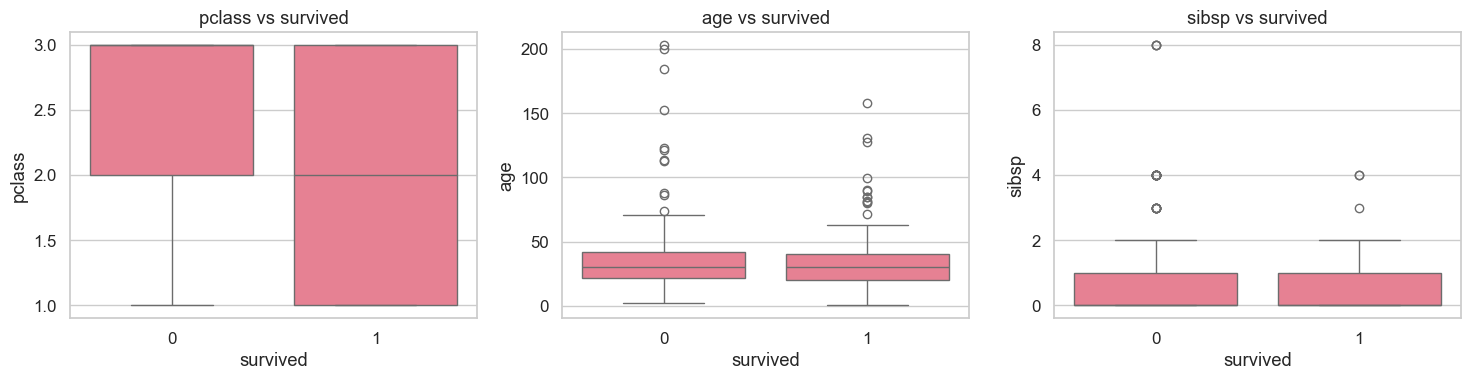

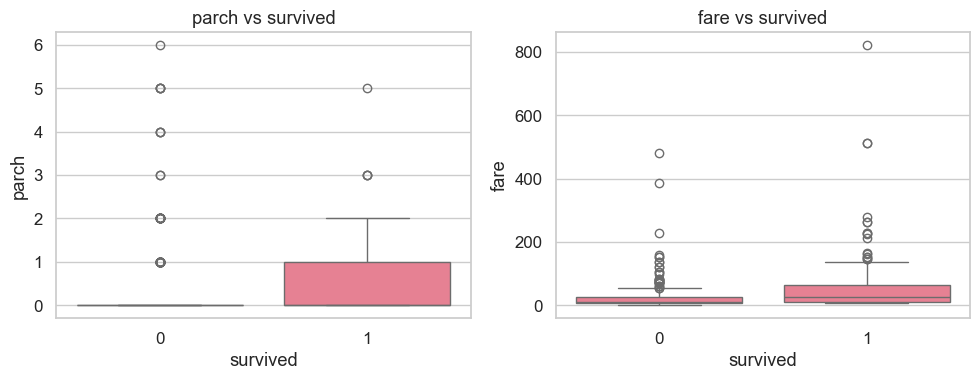

C:\Users\david\AppData\Local\Temp\ipykernel_11556\3815709943.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\david\AppData\Local\Temp\ipykernel_11556\3815709943.py:112: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


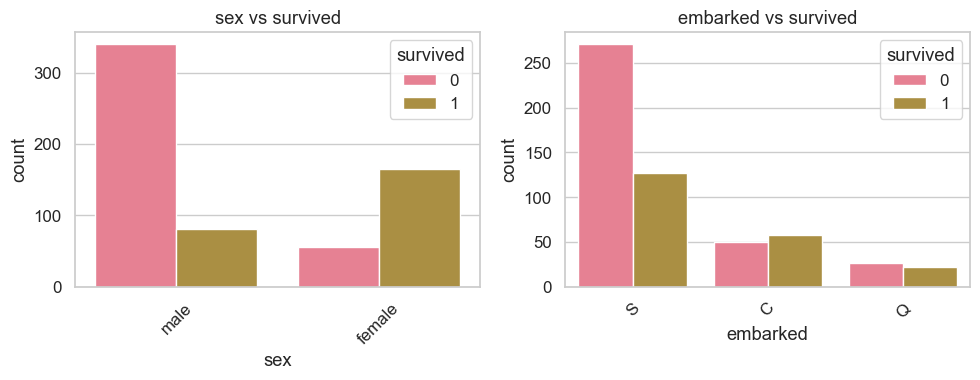

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

# Configuración de estilo
sns.set_theme(style="whitegrid", palette="husl", font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)

# Carga de datos
train_df = pd.read_csv("train_set.csv")

# Información general
print("Forma del dataset:", train_df.shape, "\n")
train_df.info()
print("\nValores nulos por columna:\n", train_df.isna().sum())
print("\nEstadísticas descriptivas:\n", train_df.describe(include="all").T)

# Separar variables numéricas y categóricas
num_cols = train_df.select_dtypes(include=np.number).columns.tolist()
cat_cols = train_df.select_dtypes(exclude=np.number).columns.tolist()

print("\nVariables numéricas:", num_cols)
print("Variables categóricas:", cat_cols)

# Distribución de variables numéricas (subplots en bloque)
if num_cols:
    cols_per_fig = 3  # número de variables numéricas por figura
    for i in range(0, len(num_cols), cols_per_fig):
        subset = num_cols[i:i + cols_per_fig]
        n_sub = len(subset)

        fig, axes = plt.subplots(2, n_sub, figsize=(5 * n_sub, 8), squeeze=False)

        for j, col in enumerate(subset):
            sns.histplot(train_df[col], kde=True, ax=axes[0, j], color='skyblue')
            axes[0, j].set_title(f'Histograma de {col}')

            sns.boxplot(x=train_df[col], ax=axes[1, j], color='orange')
            axes[1, j].set_title(f'Boxplot de {col}')

        plt.tight_layout()
        plt.show()

# Distribución de variables categóricas (subplots en bloque)
if cat_cols:
    cols_per_fig = 3
    for i in range(0, len(cat_cols), cols_per_fig):
        subset = cat_cols[i:i + cols_per_fig]
        n_sub = len(subset)

        fig, axes = plt.subplots(1, n_sub, figsize=(5 * n_sub, 4), squeeze=False)

        for j, col in enumerate(subset):
            ax = axes[0, j]
            sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index, ax=ax)
            ax.set_title(f"Distribución de {col}")
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

        plt.tight_layout()
        plt.show()

# Correlaciones
if len(num_cols) > 1:
    corr = train_df[num_cols].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Matriz de correlación")
    plt.show()

# Outliers mediante Z-score
outliers = {}
for col in num_cols:
    z = np.abs(stats.zscore(train_df[col].dropna()))
    outliers[col] = (z > 3).sum()
print("\nPosibles outliers detectados (|z|>3):\n", pd.Series(outliers))

# Relaciones con variable objetivo (si existe)
target_col = "survived"
if target_col in train_df.columns:
    # Numéricas vs target en subplots
    num_features = [c for c in num_cols if c != target_col]
    if num_features:
        cols_per_fig = 3
        for i in range(0, len(num_features), cols_per_fig):
            subset = num_features[i:i + cols_per_fig]
            n_sub = len(subset)

            fig, axes = plt.subplots(1, n_sub, figsize=(5 * n_sub, 4), squeeze=False)
            for j, col in enumerate(subset):
                ax = axes[0, j]
                sns.boxplot(x=target_col, y=col, data=train_df, ax=ax)
                ax.set_title(f"{col} vs {target_col}")
            plt.tight_layout()
            plt.show()

    # Categóricas vs target en subplots
    if cat_cols:
        cols_per_fig = 3
        for i in range(0, len(cat_cols), cols_per_fig):
            subset = cat_cols[i:i + cols_per_fig]
            n_sub = len(subset)

            fig, axes = plt.subplots(1, n_sub, figsize=(5 * n_sub, 4), squeeze=False)
            for j, col in enumerate(subset):
                ax = axes[0, j]
                sns.countplot(data=train_df, x=col, hue=target_col, ax=ax)
                ax.set_title(f"{col} vs {target_col}")
                ax.legend(title=target_col)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            plt.tight_layout()
            plt.show()

## Elemento 1 - Implementación desde cero de AdaBoost

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import mstats

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight, resample
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import joblib


In [53]:
# Tenemos que considerar que los datos que nos lleguen serán sucios ... así que la función debe implementar un preprocesamiento 



# CLASE ADABOOST SIMPLE
class SimpleAdaBoost:
    def __init__(self, n_estimators=50, base_estimator=None):
        self.n_estimators = n_estimators
        self.base_estimator = base_estimator or DecisionTreeClassifier(max_depth=1)
        self.alphas_, self.estimators_, self.errors_, self.sample_weights_ = [], [], [], []

    def fit(self, X, y):
        y = np.where(y == 0, -1, 1)
        n_samples = X.shape[0]

        # Pesos iniciales balanceados
        cw = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
        w = np.where(y == -1, cw[0], cw[1])
        w /= np.sum(w)

        # Entrenamiento iterativo
        for _ in range(self.n_estimators):
            stump = DecisionTreeClassifier(max_depth=self.base_estimator.max_depth)
            stump.fit(X, y, sample_weight=w)
            y_pred = stump.predict(X)

            err = np.clip(np.sum(w * (y_pred != y)) / np.sum(w), 1e-10, 1 - 1e-10)
            alpha = 0.5 * np.log((1 - err) / err)

            w *= np.exp(-alpha * y * y_pred)
            w /= np.sum(w)

            self.estimators_.append(stump)
            self.alphas_.append(alpha)
            self.errors_.append(err)
            self.sample_weights_.append(w.copy())

        return self

    def predict(self, X):
        pred_sum = np.sum([a * e.predict(X) for a, e in zip(self.alphas_, self.estimators_)], axis=0)
        return np.where(np.sign(pred_sum) == -1, 0, 1)

# Limpieza e ingienería de datos
def preprocess_titanic(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Imputaciones informadas
    df['age'] = df['age'].fillna(df.groupby('pclass')['age'].transform('median'))
    df['fare'] = df['fare'].fillna(df.groupby('pclass')['fare'].transform('median'))
    df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

    # Codificación de variables categóricas
    df['sex'] = df['sex'].map({'male': 0, 'female': 1}).astype(int)
    df = pd.get_dummies(df, columns=['embarked'], drop_first=True)

    # Winsorización (control de outliers)
    df['fare'] = mstats.winsorize(df['fare'], limits=[0.01, 0.01])
    df['age'] = mstats.winsorize(df['age'], limits=[0.01, 0.01])

    # Nuevas características
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = (df['family_size'] == 1).astype(int)
    df['fare_per_person'] = df['fare'] / df['family_size']
    df['is_child'] = (df['age'] < 12).astype(int)
    df['is_senior'] = (df['age'] >= 60).astype(int)
    df['sex_class'] = df['sex'].astype(str) + "_" + df['pclass'].astype(str)
    df = pd.get_dummies(df, columns=['sex_class'], drop_first=True)

    # Escalado numérico
    scaler = StandardScaler()
    num_cols = ['age', 'fare', 'sibsp', 'parch', 'pclass', 'family_size', 'fare_per_person']
    df[num_cols] = scaler.fit_transform(df[num_cols])
    joblib.dump(scaler, "scaler.pkl")


    # Convertir tipos y limpiar duplicados
    df['survived'] = df['survived'].astype(int)
    df = df.drop_duplicates()

    # Balanceo de clases
    df_major = df[df['survived'] == 0]
    df_minor = df[df['survived'] == 1]
    df_bal = pd.concat([
        df_major,
        resample(df_minor, replace=True, n_samples=len(df_major), random_state=42)
    ])
    return df_bal

In [54]:
df = pd.read_csv('train_set.csv')
df_clean = preprocess_titanic(df)

num_cols = ['age','fare','sibsp','parch','family_size','fare_per_person']
poly = PolynomialFeatures(degree=2, include_bias=False)
df_poly = pd.DataFrame(poly.fit_transform(df_clean[num_cols]), columns=poly.get_feature_names_out(num_cols))

df_enhanced = pd.concat([df_clean.drop(columns=num_cols).reset_index(drop=True), df_poly], axis=1)

X, y = df_enhanced.drop('survived', axis=1).values, df_enhanced['survived'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

simple_ada_v2 = SimpleAdaBoost(n_estimators=150, base_estimator=DecisionTreeClassifier(max_depth=2))
simple_ada_v2.fit(X_train, y_train)

# Guardar modelo
joblib.dump(simple_ada_v2, "modelo.pkl")

# Predicción y métricas
y_pred_v2 = simple_ada_v2.predict(X_test)
print("MÉTRICAS del adaboost personalizado")
print("Accuracy:", accuracy_score(y_test, y_pred_v2))
print(classification_report(y_test, y_pred_v2, digits=3))

MÉTRICAS del adaboost personalizado
Accuracy: 0.8854961832061069
              precision    recall  f1-score   support

           0      0.892     0.879     0.885        66
           1      0.879     0.892     0.885        65

    accuracy                          0.885       131
   macro avg      0.886     0.886     0.885       131
weighted avg      0.886     0.885     0.885       131



In [55]:
feature_columns = df_enhanced.drop('survived', axis=1).columns.tolist()
joblib.dump(feature_columns, "feature_columns.pkl")

['feature_columns.pkl']

C:\Users\david\AppData\Local\Temp\ipykernel_11556\1992906501.py:5: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  plt.tight_layout(); plt.show()
c:\Users\david\Documents\UADY_CARRERA\9_Noveno Semestre (UNAM)\Machine Learning\Practicas\Practica9_EnsemblesIII\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8348 (\N{LATIN SUBSCRIPT SMALL LETTER T}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


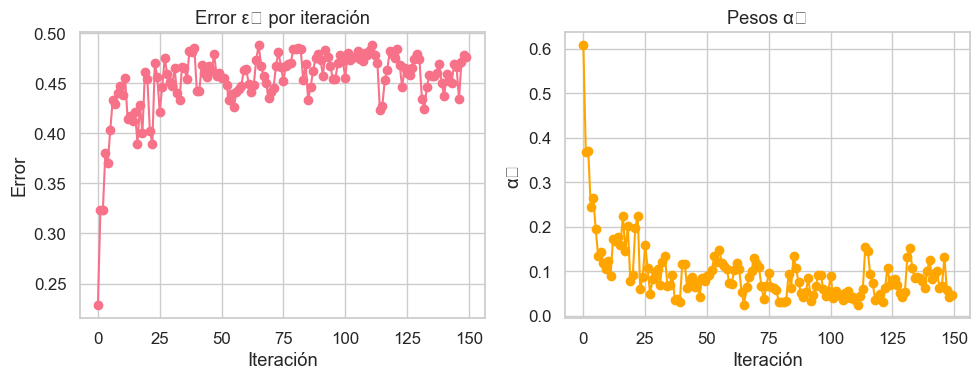

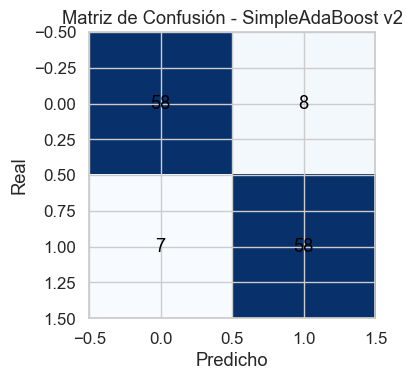

['poly.pkl']

In [56]:
# Gráficos
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(simple_ada_v2.errors_, marker='o'); plt.title("Error εₜ por iteración"); plt.xlabel("Iteración"); plt.ylabel("Error")
plt.subplot(1,2,2); plt.plot(simple_ada_v2.alphas_, marker='o', color='orange'); plt.title("Pesos αₜ"); plt.xlabel("Iteración"); plt.ylabel("αₜ")
plt.tight_layout(); plt.show()

cm = confusion_matrix(y_test, y_pred_v2)
plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues'); plt.title('Matriz de Confusión - SimpleAdaBoost v2'); plt.xlabel('Predicho'); plt.ylabel('Real')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
plt.tight_layout(); plt.show()
joblib.dump(poly, "poly.pkl")

### Elemento 1 - Preguntas teóricas

**• ¿Qué significa que un clasificador sea “débil” dentro del contexto de AdaBoost?**  
Un clasificador “débil” es aquel que tiene un rendimiento apenas mejor que el azar, es decir, su exactitud está ligeramente por encima del 50%. En AdaBoost, estos clasificadores simples —como árboles de decisión de profundidad 1 (stumps)— se combinan de forma secuencial para formar un modelo fuerte.

---

**• ¿Por qué los ejemplos mal clasificados ganan mayor peso en las iteraciones siguientes?**  
Los ejemplos mal clasificados ganan más peso porque AdaBoost busca enfocarse en los errores cometidos en las rondas anteriores. Al incrementar su peso, los siguientes clasificadores se ven obligados a prestarles más atención. Entendemos que este proceso hace que el modelo aprenda de sus errores.

---

**• ¿Qué efecto tiene aumentar el número de clasificadores débiles sobre el sesgo y la varianza?**  
Cuando aumentamos el número de clasificadores débiles, el sesgo del modelo disminuye porque el conjunto aprende patrones más complejos y se ajusta mejor a los datos. Sin embargo, si añadimos demasiados clasificadores, la varianza puede aumentar, ya que el modelo empieza a sobreajustarse al conjunto de entrenamiento.

---

**• ¿Por qué AdaBoost es sensible al ruido y a los outliers?**  
AdaBoost es sensible al ruido y a los outliers porque les asigna pesos cada vez mayores cuando son mal clasificados. Si un dato es un error o está muy lejos del patrón general, el algoritmo intentará ajustarse a él reiteradamente, distorsionando la frontera de decisión.


## Elemento 2 - Comparativa con scikit-learn

Adaboost personalizado
               precision    recall  f1-score   support

           0      0.892     0.879     0.885        66
           1      0.879     0.892     0.885        65

    accuracy                          0.885       131
   macro avg      0.886     0.886     0.885       131
weighted avg      0.886     0.885     0.885       131

Adaboost sklearn
               precision    recall  f1-score   support

           0      0.864     0.864     0.864        66
           1      0.862     0.862     0.862        65

    accuracy                          0.863       131
   macro avg      0.863     0.863     0.863       131
weighted avg      0.863     0.863     0.863       131



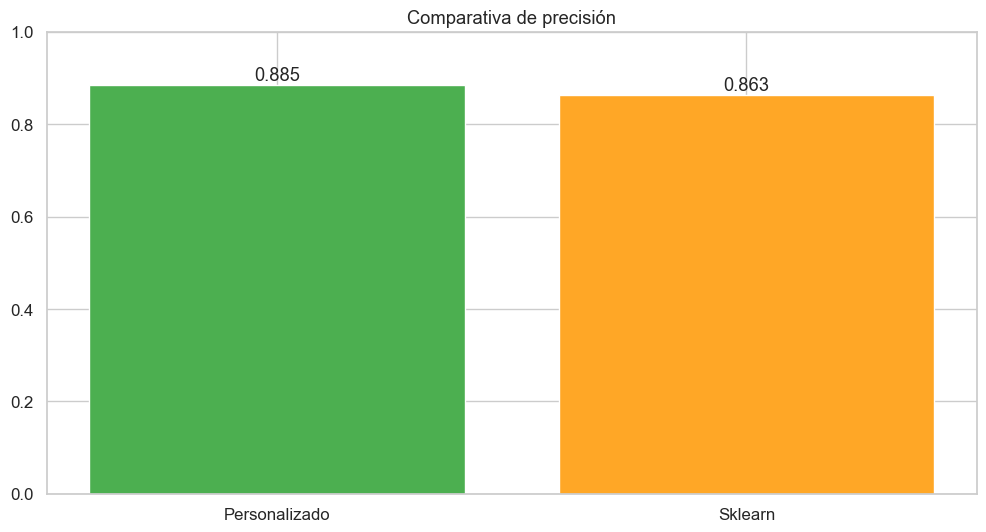

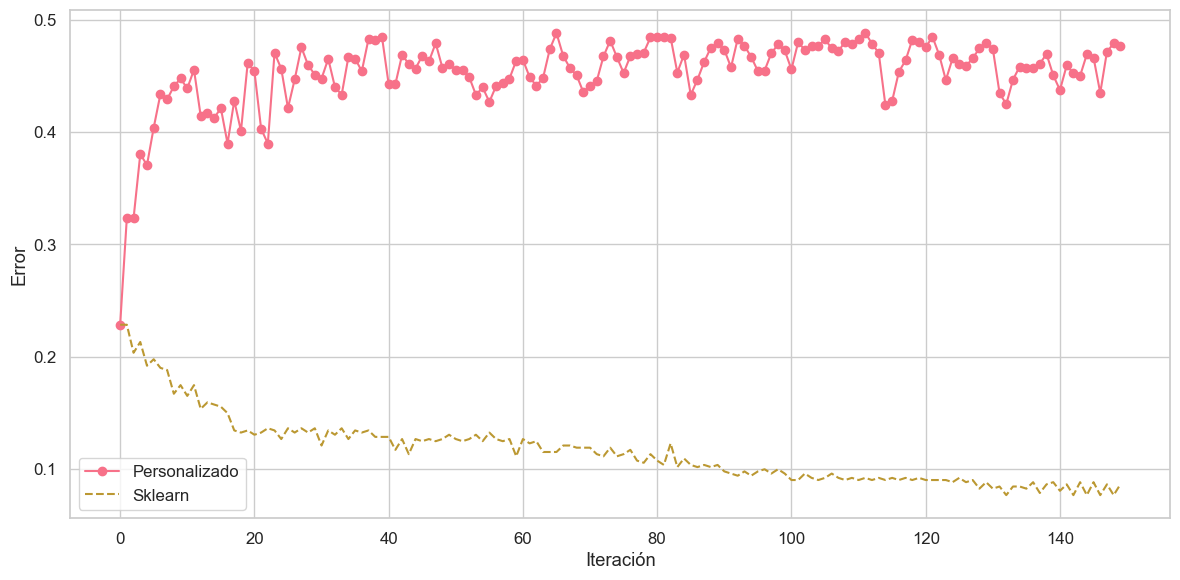

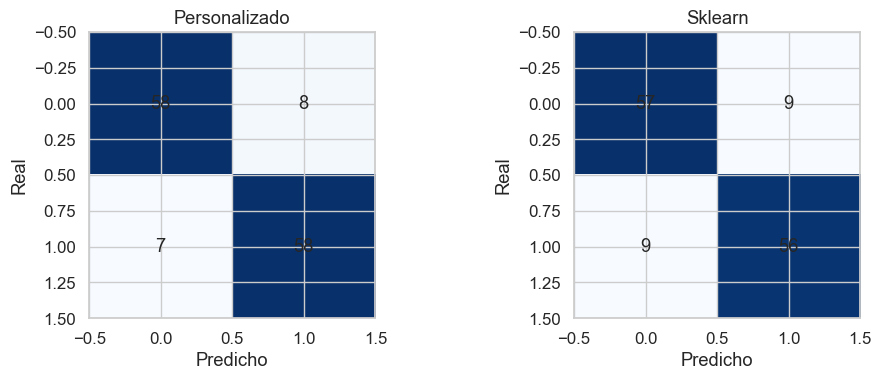

In [57]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# modelo sklearn con mismos hiperparámetros
sk_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    n_estimators=150,
    learning_rate=1.0,
    random_state=42
).fit(X_train, y_train)

# predicciones
y_pred_sk = sk_ada.predict(X_test)

# métricas
print("Adaboost personalizado\n", classification_report(y_test, y_pred_v2, digits=3))
print("Adaboost sklearn\n", classification_report(y_test, y_pred_sk, digits=3))

# accuracies comparados
acc = [accuracy_score(y_test, y_pred_v2), accuracy_score(y_test, y_pred_sk)]
plt.bar(['Personalizado','Sklearn'], acc, color=['#4CAF50','#FFA726'])
for i,v in enumerate(acc): plt.text(i,v+0.01,f'{v:.3f}',ha='center')
plt.ylim(0,1); plt.title('Comparativa de precisión'); plt.show()

# error vs iteraciones
plt.plot(simple_ada_v2.errors_, 'o-', label='Personalizado')
plt.plot(1 - np.array(list(sk_ada.staged_score(X_train, y_train))), '--', label='Sklearn')
plt.xlabel('Iteración'); plt.ylabel('Error'); plt.legend(); plt.tight_layout(); plt.show()

# matrices de confusión
cms = [confusion_matrix(y_test, y_pred_v2), confusion_matrix(y_test, y_pred_sk)]
titles = ['Personalizado','Sklearn']
fig, ax = plt.subplots(1,2,figsize=(10,4))
for i,a in enumerate(ax):
    im=a.imshow(cms[i],cmap='Blues'); a.set_title(titles[i])
    a.set_xlabel('Predicho'); a.set_ylabel('Real')
    for r in range(2):
        for c in range(2): a.text(c,r,cms[i][r,c],ha='center',va='center')
plt.tight_layout(); plt.show()


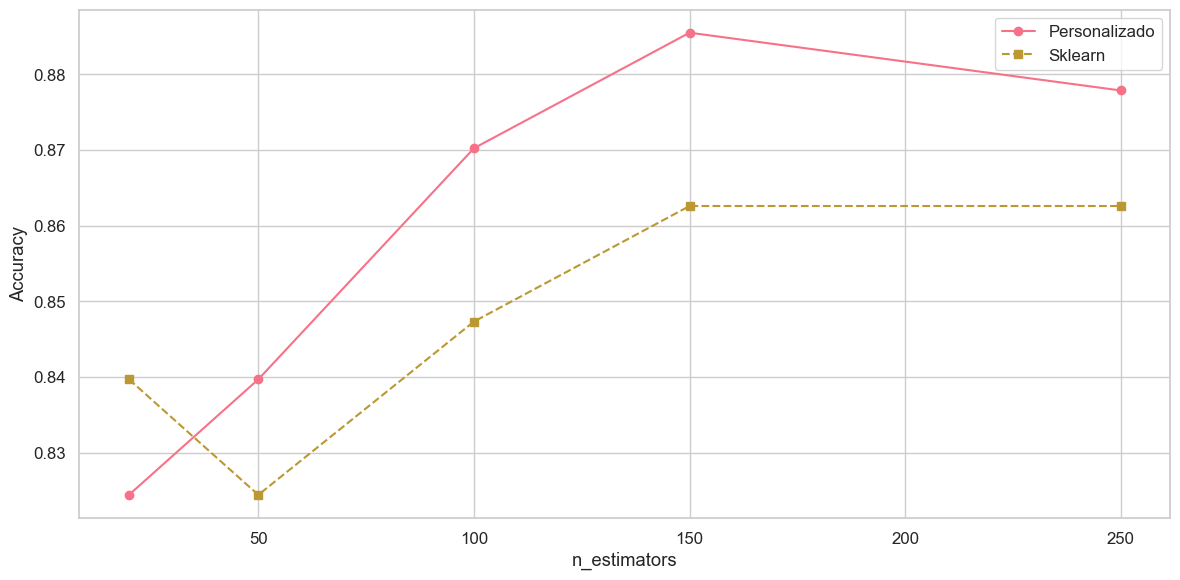

In [58]:
# comparación variando n_estimators
from sklearn.metrics import accuracy_score
vals = [20, 50, 100, 150, 250]
acc_s, acc_sk = [], []

for n in vals:
    s = SimpleAdaBoost(n_estimators=n, base_estimator=DecisionTreeClassifier(max_depth=2)).fit(X_train, y_train)
    sk = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=n, random_state=42).fit(X_train, y_train)
    acc_s.append(accuracy_score(y_test, s.predict(X_test)))
    acc_sk.append(accuracy_score(y_test, sk.predict(X_test)))

plt.plot(vals, acc_s, 'o-', label='Personalizado')
plt.plot(vals, acc_sk, 's--', label='Sklearn')
plt.xlabel('n_estimators'); plt.ylabel('Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


### Elemento 2 - Preguntas teóricas

• **¿Qué ventajas ofrece el AdaBoost implementado en scikit-learn frente a la versión básica?**  
El AdaBoost de *scikit-learn* incorpora optimizaciones numéricas que evitan inestabilidades cuando el error es extremo, ajusta los pesos con mayor precisión y maneja mejor los datos desbalanceados. También incluye parámetros como `learning_rate` para controlar la contribución de cada clasificador y tolerancias internas que mejoran la estabilidad. En conjunto, es más robusto, eficiente y menos propenso a errores numéricos.

• **¿Por qué el número de clasificadores afecta la estabilidad del modelo?**  
Porque a medida que aumenta el número de clasificadores, el modelo reduce el sesgo pero puede incrementar la varianza. Con pocos clasificadores hay subajuste, mientras que con demasiados el modelo puede empezar a aprender ruido o ejemplos atípicos, perdiendo capacidad de generalización. 

• **¿Qué sucede si algunos pesos Dₜ(i) tienden a cero o se concentran en pocos ejemplos?**  
Cuando muchos pesos se aproximan a cero, el modelo deja de prestar atención a la mayoría de los ejemplos y se enfoca solo en unos pocos difíciles o erróneos.

• **¿Cómo se puede evitar el sobreajuste en AdaBoost?**  
Se puede prevenir limitando la profundidad de los clasificadores base (por ejemplo, `max_depth=1 o 2`), usando un `learning_rate` menor a 1, aplicando regularización o deteniendo el entrenamiento cuando el error de validación empieza a aumentar. También ayuda limpiar los datos, eliminar ruido y balancear las clases para evitar concentraciones de peso excesivas.


## Elemento 3 - API, contenedor Docker y automatización con Makefile

In [59]:
df_enhanced.columns

Index(['pclass', 'sex', 'survived', 'embarked_Q', 'embarked_S', 'is_alone',
       'is_child', 'is_senior', 'sex_class_0_2', 'sex_class_0_3',
       'sex_class_1_1', 'sex_class_1_2', 'sex_class_1_3', 'age', 'fare',
       'sibsp', 'parch', 'family_size', 'fare_per_person', 'age^2', 'age fare',
       'age sibsp', 'age parch', 'age family_size', 'age fare_per_person',
       'fare^2', 'fare sibsp', 'fare parch', 'fare family_size',
       'fare fare_per_person', 'sibsp^2', 'sibsp parch', 'sibsp family_size',
       'sibsp fare_per_person', 'parch^2', 'parch family_size',
       'parch fare_per_person', 'family_size^2', 'family_size fare_per_person',
       'fare_per_person^2'],
      dtype='object')

### Elemento 3 - Preguntas teóricas

## Conclusiones de la práctica

En esta práctica comprendimos profundamente el funcionamiento del algoritmo AdaBoost, desde sus fundamentos matemáticos hasta su implementación práctica. Aprendimos cómo este método de boosting combina secuencialmente clasificadores débiles, ajustando los pesos de las observaciones mal clasificadas en cada iteración para crear un modelo ensemble robusto. La implementación desde cero nos permitió internalizar el cálculo de los pesos α_t y la actualización de la distribución D_t, mientras que la comparación con scikit-learn validó nuestra comprensión y nos mostró optimizaciones prácticas.

El desarrollo de la API REST nos enseñó la importancia del preprocesamiento consistente entre entrenamiento y producción, asegurando que el modelo reciba datos en el mismo formato. Finalmente, la containerización con Docker y automatización con Makefile nos introdujeron a las mejores prácticas de despliegue de modelos, creando un sistema reproducible y fácil de evaluar. Esta integración completa desde el algoritmo hasta el despliegue consolida el ciclo de vida de un proyecto de machine learning en producción.